<a href="https://colab.research.google.com/github/electropavuk/crypto_trader/blob/master/ipynb/Ichimoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import os
import datetime
import random
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=10, linewidth=200)
pd.options.mode.chained_assignment = None 

google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
data_dir = google_drive_dir + 'data/'

In [35]:
def load_history(filename):
    return pd.read_csv(data_dir + filename)

history = load_history('1h.csv')

In [36]:
def prepare_data(df, short, mid, long='auto'):
    long = 2 * mid if long == 'auto' else long

    df = df[['Low', 'High', 'Close']]
    low, high = df['Low'], df['High']

    df['Tenkan'] = (high.rolling(short).max() + low.rolling(short).min()) / 2
    df['Kijun'] = (high.rolling(mid).max() + low.rolling(mid).min()) / 2
    df['Senkou A'] = ((df['Tenkan'] + df['Kijun']) / 2).shift(mid)
    df['Senkou B'] = ((high.rolling(long).max() + low.rolling(long).min()) / 2).shift(mid)
    df['Chikou'] = df['Close'].shift(-mid)


    df = df.dropna()
    
    return df

In [37]:
def simulate(model, data, n, money=100, commision=0.00075):

    trades = []
    init_money = balance = money
    clean = 1 - commision
    quantity = 0

    for t in range(-n, -1):
        action = model(data, t)
        price = data['Close'].iloc[t]
        if action == 'buy' and balance > 0:
            buy_price = price
            quantity = clean * balance / price
            balance = 0
            trades.append(('buy', t, price, balance))
        elif action == 'sell' and quantity > 0:
            balance = clean * quantity * price
            trades.append(('sell', t, price, balance))
            quantity = 0
    
    if quantity > 0:
        balance += quantity * buy_price
        trades.pop()
    
    profit = (balance - init_money) / init_money
    return trades, profit

In [38]:
def config_plot(plt):
    plt.figure(figsize = (30, 5))
    plt.margins(0, .1)
    plt.grid(True)

def show_graph(data, trades):
    xsell, ysell, xbuy, ybuy = [], [], [], []
    for action, t, price, _ in trades:
        if action == 'buy':
            xbuy.append(t)
            ybuy.append(price)
        if action == 'sell':
            xsell.append(t)
            ysell.append(price)

    config_plot(plt)



    x = range(-n, 0)

    # Ichimoku
    plt.plot(x, data['Tenkan'], label='Tenkan', c='blue', linewidth=1)
    plt.plot(x, data['Kijun'], label='Kijun', c='darkred', linewidth=1)
    plt.plot(x, data['Senkou A'], label='Senkou A', c='green', linewidth=1)
    plt.plot(x, data['Senkou B'], label='Senkou B', c='red', linewidth=1)
    plt.plot(x, data['Chikou'], label='Chikou', c='lawngreen', linewidth=1)

    
    # Price and trades
    plt.title('{} trades made, profit'.format(len(trades)))
    plt.plot(x, data['Close'].iloc[-n:], label='Closing price', c='black')

    plt.scatter(xbuy, ybuy, label='Buy', c='blue')
    plt.scatter(xsell, ysell, label='Sell', c='red')
    plt.legend()




def show_profit(data, trades):
    config_plot(plt)
    xprofit, yprofit = [], []
    balance = init_money = money
    for action, t, price, balance in trades:
        if balance > 0:
            xprofit.append(t)
            yprofit.append(100 * (balance - init_money) / init_money)


    plt.title('Profit')
    plt.plot(xprofit, yprofit, label='Profit', c='black', linestyle=':')
    plt.legend()

In [39]:
class Ichimoku:
    def __init__(self, short=None, mid=None, long=None, patience=1, max_hold=10**6, **kwargs):
        self.short, self.mid, self.long = short, mid, long

        self.patience = patience
        self.max_hold = max_hold
        self.short, self.mid, self.long = short, mid, long
        self.cur_hold = 0
        self.bought = False
    
    def get_lines(self, data, t):
        close = data['Close'].iloc[t - self.patience: t + 1].values
        tenkan = data['Tenkan'].iloc[t - self.patience: t + 1].values
        kijun = data['Kijun'].iloc[t - self.patience: t + 1].values
        senkou_a = data['Senkou A'].iloc[t - self.patience: t + 1].values
        senkou_b = data['Senkou B'].iloc[t - self.patience: t + 1].values
        chikou = data['Chikou'].iloc[t - self.patience: t + 1].values
        return close, tenkan, kijun, senkou_a, senkou_b, chikou

    def action(self, buy_signal, sell_signal):
        buy_signal, sell_signal = all(buy_signal), all(sell_signal)

        if self.bought:
            self.cur_hold += 1

        if buy_signal and not self.bought:
            self.bought = True
            return 'buy'
        elif sell_signal or self.cur_hold == self.max_hold:
            self.bought = False
            self.cur_hold = 0
            return 'sell'
        else:
            return 'wait'



# Tenkan and Kijun crossover
# buy when Tenkan crosses Kijun from bottom to top
# sell when Tenkan crosses Kijun from top to bottom.
class TenkanKijunCrossover(Ichimoku):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, data, t):
        close, tenkan, kijun, senkou_a, senkou_b, chikou = self.get_lines(data, t)
        diff = tenkan > kijun
        if not diff[0] and all(diff[1:]):
            return 'buy'
        elif diff[0] and not any(diff[1:]):
            return 'sell'
        else:
            return 'wait'


# Senku A and Senku B crossover
# buy when Senku A crosses Senku B from bottom to top
# sell when Senku A crosses Senku B from top to bottom.
class SenkuASenkuBCrossover(Ichimoku):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, data, t):
        close, tenkan, kijun, senkou_a, senkou_b, chikou = self.get_lines(data, t)
        diff = senkou_a > senkou_b
        if not diff[0] and all(diff[1:]):
            return 'buy'
        elif diff[0] and not any(diff[1:]):
            return 'sell'
        else:
            return 'wait'


# NOT WORKING

# # Chikou and Close crossover
# # buy when Chikou crosses Close from bottom to top
# # sell when Chikou crosses Close from top to bottom.
# class ChikouCrossover(Ichimoku):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

#     def __call__(self, data, t):
#         if -t + self.mid + self.patience > n:
#             return 'wait'
#         close, tenkan, kijun, senkou_a, senkou_b, chikou = self.get_lines(data, t - self.mid)
#         # chikou = data['Close'].iloc[t]
#         # close = data['Close'].iloct[t - self.mid]
#         diff = chikou > close
#         if not diff[0] and all(diff[1:]):
#             return 'buy'
#         elif diff[0] and not any(diff[1:]):
#             return 'sell'
#         else:
#             return 'wait'

In [40]:
def search_parameters(short, mid):
    params = product(short, mid)
    params = [(a, b) for a, b in params if a < b]

    profits = []
    for short, mid in params:
        data = prepare_data(history, short, mid)
        trades, profit = simulate(model, data, n, money=money, commision=0.00075)
        print('params {} : profit = {:.1f} %'.format((short, mid), profit * 100))
        profits.append((profit, (short, mid)))

    profit, (short, mid) = max(profits)
    print('BEST')
    print('params {} : profit = {:.1f} %'.format((short, mid), profit * 100))
    return short, mid












MODEL [ Tenkan and Kijun crossover ]
short 7, mid 16, profit 192.3997385102944 %


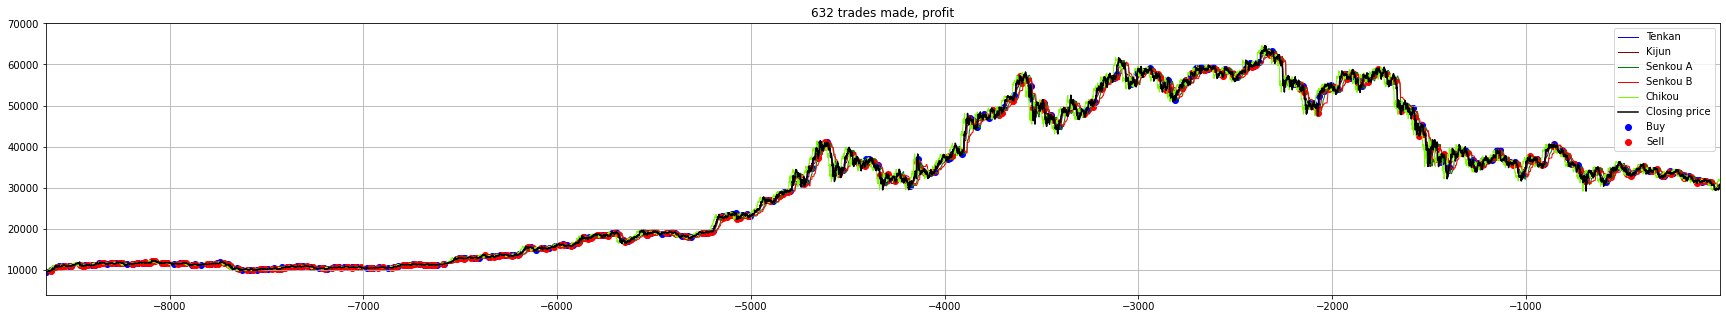

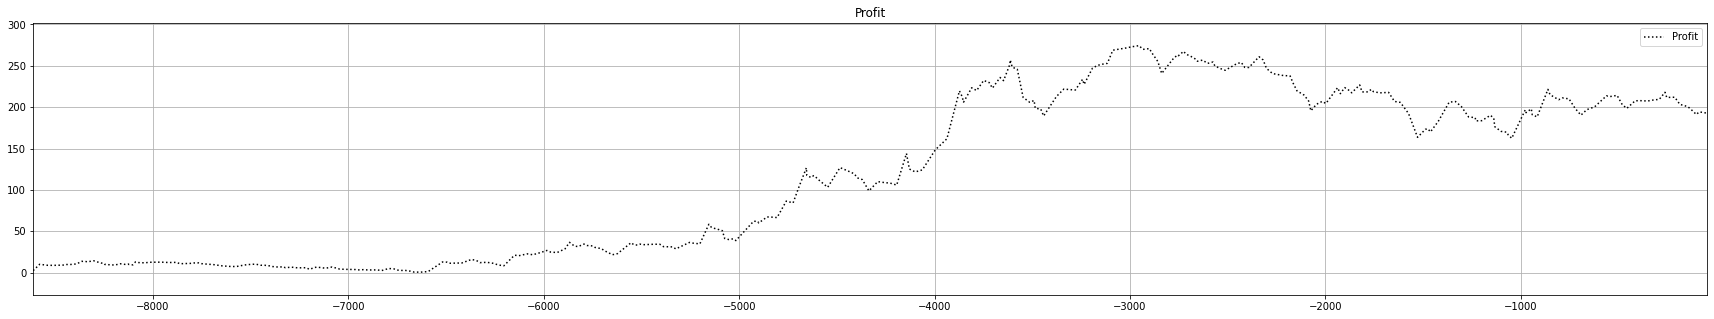












MODEL [ Senku A and Senku B crossover ]
short 17, mid 24, profit 134.82779154666486 %


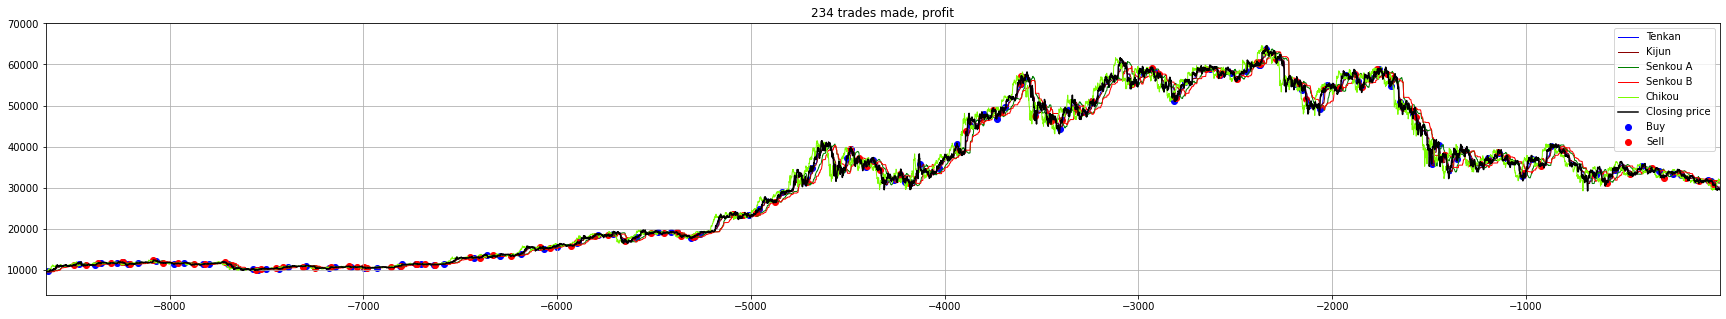

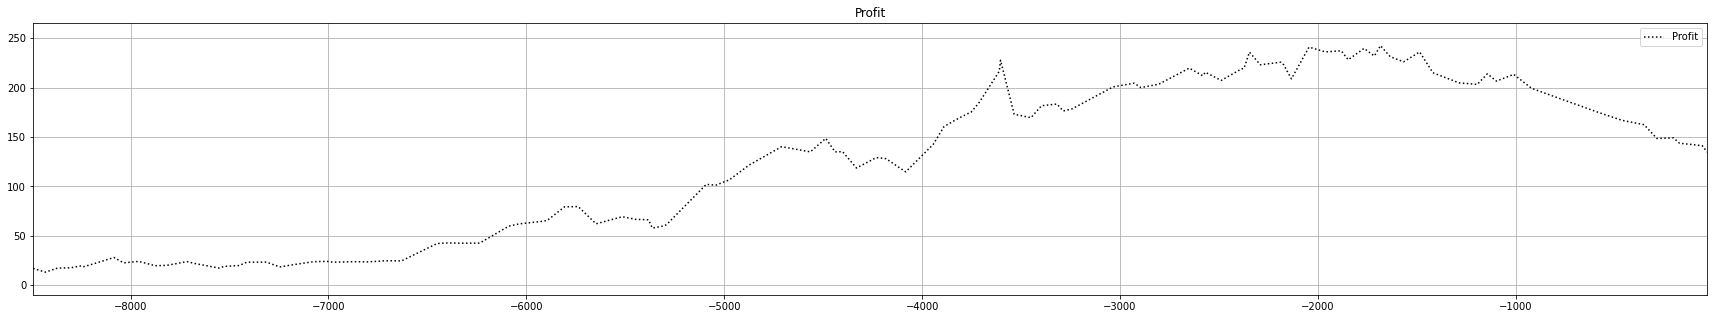

In [42]:
money = 100
n = 24 * 360
data = prepare_data(history, short, mid, long)[-n:]

# short, mid = 9, 14 # 1h, 60 days
# short, mid = 7, 16 # 1h, 360 days
# model = TenkanKijunCrossover()

# short, mid = 13, 16 # 1h, 60 days
# short, mid = 17, 24 # 1h, 360 days
# model = SenkuASenkuBCrossover() # very bad


# short, mid = search_parameters(range(5, 20, 2), range(10, 35, 2))


for model, params, name in zip([TenkanKijunCrossover(), SenkuASenkuBCrossover()],
                               [(7, 16), (17, 24)],
                               ['Tenkan and Kijun crossover', 'Senku A and Senku B crossover']):
    
    short, mid = params
    data = prepare_data(history, short=short, mid=mid)[-n:]
    trades, profit = simulate(model, data, n, money=money, commision=0.00075)

    print('\n' * 10)
    print(f'MODEL [ {name} ]')
    print(f'short {short}, mid {mid}, profit {profit * 100} %')

    show_graph(data, trades)
    show_profit(data, trades)
    plt.show()